In [3]:
%matplotlib inline
import time
import imageio

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython.display import clear_output

In [ ]:
class SamplePool:
    def __init__(self, *, _parent=None, _parent_idx=None, **slots):
        self._parent = _parent
        self._parent_idx = _parent_idx
        self._slot_names = slots.keys()
        self._size = None
        for k, v in slots.items():
            if self._size is None:
                self._size = len(v)
            assert self._size == len(v)
            setattr(self, k, np.asarray(v))

    def sample(self, n):
        idx = np.random.choice(self._size, n, False)
        batch = {k: getattr(self, k)[idx] for k in self._slot_names}
        batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
        return batch

    def commit(self):
        for k in self._slot_names:
            getattr(self._parent, k)[self._parent_idx] = getattr(self, k)


def to_alpha(x):
    return np.clip(x[..., 3:4], 0, 0.9999)


def to_rgb(x):
    # assume rgb premultiplied by alpha
    rgb, a = x[..., :3], to_alpha(x)
    return np.clip(1.0 - a + rgb, 0, 0.9999)


def get_living_mask(x):
    return nn.MaxPool2d(3, stride=1, padding=1)(x[:, 3:4, :, :]) > 0.1


def make_seeds(shape, n_channels, n=1):
    x = np.zeros([n, shape[0], shape[1], n_channels], np.float32)
    x[:, shape[0] // 2, shape[1] // 2, 3:] = 1.0
    return x


def make_seed(shape, n_channels):
    seed = np.zeros([shape[0], shape[1], n_channels], np.float32)
    seed[shape[0] // 2, shape[1] // 2, 3:] = 1.0
    return seed


def make_circle_masks(n, h, w):
    x = np.linspace(-1.0, 1.0, w)[None, None, :]
    y = np.linspace(-1.0, 1.0, h)[None, :, None]
    center = np.random.random([2, n, 1, 1]) * 1.0 - 0.5
    r = np.random.random([n, 1, 1]) * 0.3 + 0.1
    x, y = (x - center[0]) / r, (y - center[1]) / r
    mask = (x * x + y * y < 1.0).astype(np.float32)
    return mask

In [ ]:
class CAModel(nn.Module):
    def __init__(self, channel_n, fire_rate, device, hidden_size=128):
        super(CAModel, self).__init__()

        self.device = device
        self.channel_n = channel_n

        self.fc0 = nn.Linear(channel_n * 3, hidden_size)
        self.fc1 = nn.Linear(hidden_size, channel_n, bias=False)
        with torch.no_grad():
            self.fc1.weight.zero_()

        self.fire_rate = fire_rate
        self.to(self.device)

    def alive(self, x):
        return F.max_pool2d(x[:, 3:4, :, :], kernel_size=3, stride=1, padding=1) > 0.1

    def perceive(self, x, angle):

        def _perceive_with(x, weight):
            conv_weights = torch.from_numpy(weight.astype(np.float32)).to(self.device)
            conv_weights = conv_weights.view(1, 1, 3, 3).repeat(self.channel_n, 1, 1, 1)
            return F.conv2d(x, conv_weights, padding=1, groups=self.channel_n)

        dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
        dy = dx.T
        c = np.cos(angle * np.pi / 180)
        s = np.sin(angle * np.pi / 180)
        w1 = c * dx - s * dy
        w2 = s * dx + c * dy

        y1 = _perceive_with(x, w1)
        y2 = _perceive_with(x, w2)
        y = torch.cat((x, y1, y2), 1)
        return y

    def update(self, x, fire_rate, angle):
        x = x.transpose(1, 3)
        pre_life_mask = self.alive(x)

        dx = self.perceive(x, angle)
        dx = dx.transpose(1, 3)
        dx = self.fc0(dx)
        dx = F.relu(dx)
        dx = self.fc1(dx)

        if fire_rate is None:
            fire_rate = self.fire_rate
        stochastic = torch.rand([dx.size(0), dx.size(1), dx.size(2), 1]) > fire_rate
        stochastic = stochastic.float().to(self.device)
        dx = dx * stochastic

        x = x + dx.transpose(1, 3)

        post_life_mask = self.alive(x)
        life_mask = (pre_life_mask & post_life_mask).float()
        x = x * life_mask
        return x.transpose(1, 3)

    def forward(self, x, steps=1, fire_rate=None, angle=0.0):
        for step in range(steps):
            x = self.update(x, fire_rate, angle)
        return x

In [ ]:
def load_emoji(index, path="emoji.png"):
    im = imageio.imread(path)
    emoji = np.array(im[:, index * 40 : (index + 1) * 40].astype(np.float32))
    emoji /= 255.0
    return emoji


def visualize_batch(x0, x):
    vis0 = to_rgb(x0)
    vis1 = to_rgb(x)
    print("batch (before/after):")
    plt.figure(figsize=[15, 5])
    for i in range(x0.shape[0]):
        plt.subplot(2, x0.shape[0], i + 1)
        plt.imshow(vis0[i])
        plt.axis("off")
    for i in range(x0.shape[0]):
        plt.subplot(2, x0.shape[0], i + 1 + x0.shape[0])
        plt.imshow(vis1[i])
        plt.axis("off")
    plt.show()


def plot_loss(loss_log):
    plt.figure(figsize=(10, 4))
    plt.title("Loss history (log10)")
    plt.plot(np.log10(loss_log), ".", alpha=0.1)
    plt.show()

In [ ]:
device = torch.device("cuda:0")
model_path = "remaster_1.pth"

CHANNEL_N = 16  # Number of CA state channels
TARGET_PADDING = 16  # Number of pixels used to pad the target image border
TARGET_SIZE = 40

lr = 2e-3
lr_gamma = 0.9999
betas = (0.5, 0.5)
n_epoch = 80000

BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = 1  # @param "🦎"

EXPERIMENT_TYPE = "Regenerating"
EXPERIMENT_MAP = {"Growing": 0, "Persistent": 1, "Regenerating": 2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

C:\Users\ernan\AppData\Local\Temp\ipykernel_35288\2091800596.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(path)


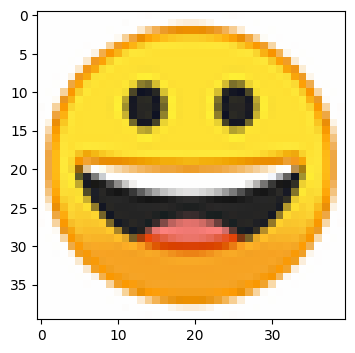

In [ ]:
target_img = load_emoji(TARGET_EMOJI)
plt.figure(figsize=(4, 4))
plt.imshow(to_rgb(target_img))
plt.show()

In [10]:
p = TARGET_PADDING
pad_target = np.pad(target_img, [(p, p), (p, p), (0, 0)])
h, w = pad_target.shape[:2]
pad_target = np.expand_dims(pad_target, axis=0)
pad_target = torch.from_numpy(pad_target.astype(np.float32)).to(device)

seed = make_seed((h, w), CHANNEL_N)
pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))
batch = pool.sample(BATCH_SIZE).x

ca = CAModel(CHANNEL_N, CELL_FIRE_RATE, device).to(device)
ca.load_state_dict(torch.load(model_path))

optimizer = optim.Adam(ca.parameters(), lr=lr, betas=betas)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_gamma)

0 loss = 0.018083270639181137
batch (before/after):


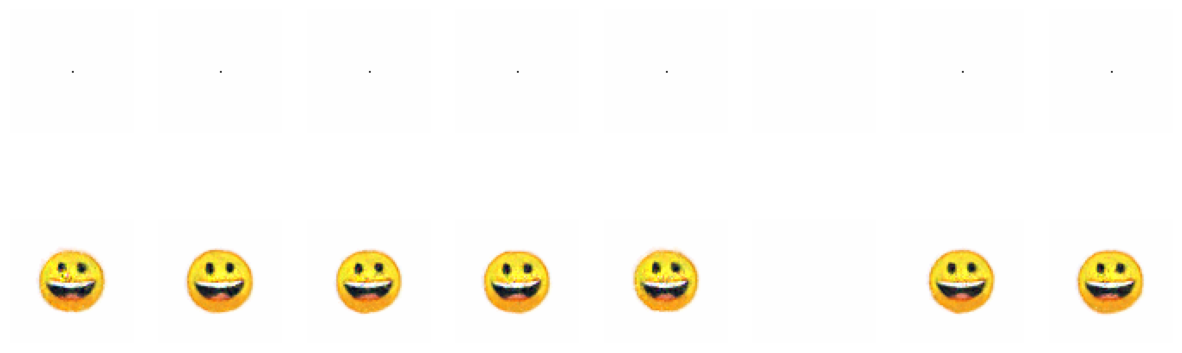

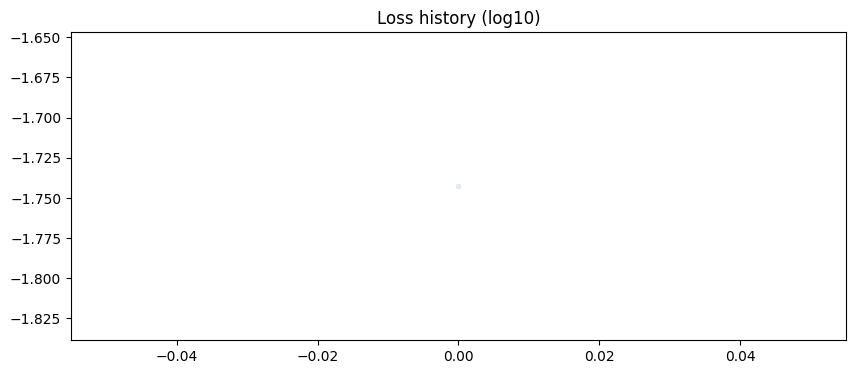

KeyboardInterrupt: 

In [ ]:
loss_log = []


def train(x, target, steps, optimizer, scheduler):
    x = ca(x, steps=steps)
    loss = F.mse_loss(x[:, :, :, :4], target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    return x, loss


def loss_f(x, target):
    return torch.mean(torch.pow(x[..., :4] - target, 2), [-2, -3, -1])


for i in range(n_epoch + 1):
    if USE_PATTERN_POOL:
        batch = pool.sample(BATCH_SIZE)
        x0 = torch.from_numpy(batch.x.astype(np.float32)).to(device)
        loss_rank = loss_f(x0, pad_target).detach().cpu().numpy().argsort()[::-1]
        x0 = batch.x[loss_rank]
        x0[:1] = seed
        if DAMAGE_N:
            damage = 1.0 - make_circle_masks(DAMAGE_N, h, w)[..., None]
            x0[-DAMAGE_N:] *= damage
    else:
        x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)
    x0 = torch.from_numpy(x0.astype(np.float32)).to(device)

    x, loss = train(x0, pad_target, np.random.randint(64, 96), optimizer, scheduler)

    if USE_PATTERN_POOL:
        batch.x[:] = x.detach().cpu().numpy()
        batch.commit()

    step_i = len(loss_log)
    loss_log.append(loss.item())

    if step_i % 100 == 0:
        clear_output()
        print(step_i, "loss =", loss.item())
        visualize_batch(x0.detach().cpu().numpy(), x.detach().cpu().numpy())
        plot_loss(loss_log)
        torch.save(ca.state_dict(), model_path)